In this notebook, I will perform the following tasks:
1.) Encode Data 
2.) Standardize Data
3.) Feature Selection and Feature Engineering
4.) Fit Models
5.) Evaluate Models

In [922]:

# Set the environment to limit MKL threads
import os
from idlelib.pyparse import trans

os.environ['OMP_NUM_THREADS']= '5'

In [923]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder, OrdinalEncoder, RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler, MaxAbsScaler
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import plotly.graph_objects as go

In [924]:
# Load Data

data = pd.read_csv('tech_df_cleaned.csv', index_col=None)
data.describe(include='all')

,number_of_employees,tech_company,mental_health_benefits,mental_health_coverage_awareness,mental_health_offical_communication,mental_health_resources,mental_health_anonymity,asking_for_leave_for_mental_health,discussing_mental_health_with_employer,discussing_physical_health_with_employer,...,at_any_point_diagnosed_MH_disorder,treatment_MH_disorder,interference_with_work_with_effective_treatment,interference_with_work_NOT_effective_treatment,gender,country_residence,country_work,work_position,remote_work,age_group
count,1146,1146,1146,1146,1146,1146,1146,1146,1146,1146,...,1146,1146,1146,1146,1146,1146,1146,1146,1146,1146
unique,6,2,4,4,3,3,3,6,3,3,...,2,2,5,5,3,7,7,180,3,6
top,26-100,Yes,Yes,No,No,No,I don't know,Somewhat easy,Maybe,No,...,No,Yes,Not applicable to me,Often,Male,North America,North America,Back-end Developer,Sometimes,30-39
freq,292,883,531,354,813,531,742,281,487,837,...,579,657,455,422,846,774,779,238,611,543


In [925]:
# Create a data frame to show all features and their unique values. This will help me determine which features to encode using OneHotEncoder, MultiLabelBinarizer, or OrdinalEncoder.

unique_categories = {}

for column in data.columns:
    unique_categories[column] = data[column].unique()
    
# Convert dictionary to data frame
unique_categories_df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in unique_categories.items() ]))

# Display data frame
unique_categories_df



,number_of_employees,tech_company,mental_health_benefits,mental_health_coverage_awareness,mental_health_offical_communication,mental_health_resources,mental_health_anonymity,asking_for_leave_for_mental_health,discussing_mental_health_with_employer,discussing_physical_health_with_employer,...,at_any_point_diagnosed_MH_disorder,treatment_MH_disorder,interference_with_work_with_effective_treatment,interference_with_work_NOT_effective_treatment,gender,country_residence,country_work,work_position,remote_work,age_group
0,26-100,Yes,Not eligible for coverage / N/A,Missing,No,No,I don't know,Very easy,No,No,...,Yes,No,Not applicable to me,Not applicable to me,Male,Europe,Europe,Back-end Developer,Sometimes,30-39
1,6-25,No,No,Yes,Yes,Yes,Yes,Somewhat easy,Maybe,Maybe,...,No,Yes,Rarely,Sometimes,Female,North America,North America,Back-end Developer|Front-end Developer,Never,20-29
2,More than 1000,NaN,Yes,I am not sure,I don't know,I don't know,No,Neither easy nor difficult,Yes,Yes,...,NaN,NaN,Sometimes,Often,Other/Non-Binary,Oceania,Oceania,Executive Leadership|Supervisor/Team Lead|Dev ...,Always,40-49
3,100-500,NaN,I don't know,No,NaN,NaN,NaN,Very difficult,NaN,NaN,...,NaN,NaN,Never,Rarely,NaN,South America,South America,DevOps/SysAdmin|Support|Back-end Developer|Fro...,NaN,50-59
4,500-1000,NaN,NaN,NaN,NaN,NaN,NaN,Somewhat difficult,NaN,NaN,...,NaN,NaN,Often,Never,NaN,Asia,Asia,Dev Evangelist/Advocate|Back-end Developer,NaN,< 20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Support|Back-end Developer|Front-end Developer...,NaN,NaN
176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Dev Evangelist/Advocate|DevOps/SysAdmin|Suppor...,NaN,NaN
177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Other|Supervisor/Team Lead|Dev Evangelist/Advo...,NaN,NaN
178,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Supervisor/Team Lead|Back-end Developer|Designer,NaN,NaN


In [926]:
# Figure out how to use the OrdinalEncoder. 

ordinal_features_categories = {
    'number_of_employees': ['1-5', '6-25', '26-100', '100-500', '500-1000', 'More than 1000'], 
    'asking_for_leave_for_mental_health':["I don't know", "Very difficult", "Somewhat difficult", "Neither easy nor difficult", "Somewhat easy", "Very easy"], 
    'previous_employer_mental_health_benefits': ["No Previous Employer", "I don't know", "No, none did", "Some did", "Yes, they all did"],
    'previous_employer_mental_health_coverage_awareness':["No Previous Employer", "N/A (not currently aware)", "No, I only became aware later","I was aware of some", "Yes, I was aware of all of them"], 
    'previous_employer_mental_health_official_communication': ["No Previous Employer", "I don't know", "None did", "Some did", "Yes, they all did"],
    'previous_employer_mental_health_resources': ["No Previous Employer", "None did", "Some did", "Yes, they all did"],
    'previous_employer_mental_health_anonymity': ["No Previous Employer", "I don't know", "No", "Sometimes", "Yes, always"],
    'discussing_mental_health_with_previous_employer': ["No Previous Employer", "I don't know", "None of them", "Some of them", "Yes, all of them"],
    'discussing_physical_health_with_previous_employer': ["No Previous Employer", "None of them", "Some of them", "Yes, all of them"],
    'reveal_mental_diagnoses_previous_coworkers': ['No Previous Employer', 'No, at none of my previous employers', 'Some of my previous employers', 'Yes, at all of my previous employers'],
    'reveal_mental_diagnoses_previous_supervisor':['No Previous Employer', "I don't know", 'No, at none of my previous employers', 'Some of my previous employers', 'Yes, at all of my previous employers'],
    'previous_employer_physical_same_mental':["No Previous Employer","I don't know", "None did", "Some did", "Yes, they all did"],
    'previous_employer_neg_consequences_open_mental_health':["No Previous Employer", "None of them", "Some of them", "Yes, all of them"],
    'share_mental_illness_loved_ones':["Not applicable to me (I do not have a mental illness)", "Not open at all", "Somewhat not open", "Neutral",  "Somewhat open", "Very open"],
    'interference_with_work_with_effective_treatment': ['Not applicable to me', 'Never', 'Rarely', 'Sometimes', 'Often'],
    'interference_with_work_NOT_effective_treatment': ['Not applicable to me', 'Never', 'Rarely', 'Sometimes', 'Often'],
    'age_group': ['< 20', '20-29', '30-39', '40-49', '50-59', '60+'],
    'remote_work':['Never', 'Sometimes', 'Always'],
    'discussing_mental_health_with_employer': ['No', 'Maybe','Yes'],
    'discussing_physical_health_with_employer': ['No', 'Maybe','Yes'],
    'discussing_mental_health_with_coworker': ['No', 'Maybe','Yes'],
    'discussing_mental_health_with_supervisor': ['No', 'Maybe','Yes'],
    'physical_health_interview': ['No', 'Maybe','Yes'],
    'mental_health_interview': ['No', 'Maybe','Yes'],
    'current_employment_less_likely_to_reveal_mental_health_issue':['Missing', 'No', 'Maybe','Yes'],
    'past_history_mental_health': ['No', 'Maybe','Yes'],
    'current_MH_disorder': ['No', 'Maybe','Yes']
}

# Initialize OrdinalEncoder with categories from ordinal_features dictionary
ordinal_encoder = OrdinalEncoder(categories=list(ordinal_features_categories.values()))

# Fit and transform data the ordinal features

ordinal_encoded = ordinal_encoder.fit_transform(data[list(ordinal_features_categories.keys())])

ordinal_encoded_data = pd.DataFrame(ordinal_encoded, columns=list(ordinal_features_categories.keys()))
ordinal_encoded_data.head()


,number_of_employees,asking_for_leave_for_mental_health,previous_employer_mental_health_benefits,previous_employer_mental_health_coverage_awareness,previous_employer_mental_health_official_communication,previous_employer_mental_health_resources,previous_employer_mental_health_anonymity,discussing_mental_health_with_previous_employer,discussing_physical_health_with_previous_employer,reveal_mental_diagnoses_previous_coworkers,...,remote_work,discussing_mental_health_with_employer,discussing_physical_health_with_employer,discussing_mental_health_with_coworker,discussing_mental_health_with_supervisor,physical_health_interview,mental_health_interview,current_employment_less_likely_to_reveal_mental_health_issue,past_history_mental_health,current_MH_disorder
0,2.0,5.0,2.0,1.0,1.0,1.0,1.0,3.0,1.0,2.0,...,1.0,0.0,0.0,1.0,2.0,1.0,1.0,0.0,2.0,0.0
1,1.0,4.0,4.0,3.0,2.0,2.0,4.0,2.0,1.0,1.0,...,0.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,2.0,2.0
2,1.0,3.0,2.0,1.0,2.0,2.0,1.0,1.0,2.0,2.0,...,2.0,1.0,0.0,1.0,1.0,2.0,2.0,3.0,1.0,0.0
3,1.0,3.0,1.0,1.0,3.0,1.0,1.0,3.0,2.0,1.0,...,1.0,2.0,1.0,1.0,0.0,1.0,0.0,3.0,2.0,2.0
4,5.0,4.0,2.0,4.0,2.0,1.0,1.0,4.0,2.0,1.0,...,1.0,2.0,2.0,1.0,2.0,2.0,1.0,1.0,0.0,2.0


In [927]:
# Add encoded data to original data frame
data = pd.concat([data.drop(columns=list(ordinal_features_categories.keys())), ordinal_encoded_data], axis=1)

In [928]:
# Use MultiLabelBinarizer to encode work_position because some participants have multiple roles

one_hot_multiclass = MultiLabelBinarizer()
data_encoded = one_hot_multiclass.fit_transform(data['work_position'].str.split('|'))
data = pd.concat([data.drop(columns=['work_position']), pd.DataFrame(data_encoded, columns=one_hot_multiclass.classes_)], axis=1)
data.head()



,tech_company,mental_health_benefits,mental_health_coverage_awareness,mental_health_offical_communication,mental_health_resources,mental_health_anonymity,physical_same_mental,neg_consequences_open_mental_health,previous_employer,mental_health_career_impact,...,Dev Evangelist/Advocate,DevOps/SysAdmin,Executive Leadership,Front-end Developer,HR,One-person shop,Other,Sales,Supervisor/Team Lead,Support
0,Yes,Not eligible for coverage / N/A,Missing,No,No,I don't know,I don't know,No,Yes,Maybe,...,0,0,0,0,0,0,0,0,0,0
1,Yes,No,Yes,Yes,Yes,Yes,Yes,No,Yes,"No, I don't think it would",...,0,0,0,1,0,0,0,0,0,0
2,Yes,No,Missing,No,No,I don't know,I don't know,No,Yes,Maybe,...,0,0,0,0,0,0,0,0,0,0
3,No,Yes,Yes,No,No,No,No,No,Yes,"Yes, I think it would",...,1,1,1,1,0,0,0,0,1,1
4,Yes,Yes,I am not sure,No,Yes,Yes,No,Yes,Yes,"Yes, I think it would",...,0,1,0,1,0,0,0,0,0,1


In [929]:
# Use OneHotEncoder to encode the rest of the categorical variables

categorical_columns = data.select_dtypes(include='object').columns.tolist()
encoder = OneHotEncoder(sparse_output=False, drop='if_binary')

one_hot_encoded = encoder.fit_transform(data[categorical_columns])
one_hot_data =pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))
data = pd.concat([data.drop(columns=categorical_columns), one_hot_data], axis=1)

data.head()


,number_of_employees,asking_for_leave_for_mental_health,previous_employer_mental_health_benefits,previous_employer_mental_health_coverage_awareness,previous_employer_mental_health_official_communication,previous_employer_mental_health_resources,previous_employer_mental_health_anonymity,discussing_mental_health_with_previous_employer,discussing_physical_health_with_previous_employer,reveal_mental_diagnoses_previous_coworkers,...,country_residence_Other,country_residence_South Africa,country_residence_South America,country_work_Asia,country_work_Europe,country_work_North America,country_work_Oceania,country_work_Other,country_work_South Africa,country_work_South America
0,2.0,5.0,2.0,1.0,1.0,1.0,1.0,3.0,1.0,2.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,4.0,4.0,3.0,2.0,2.0,4.0,2.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.0,3.0,2.0,1.0,2.0,2.0,1.0,1.0,2.0,2.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1.0,3.0,1.0,1.0,3.0,1.0,1.0,3.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,5.0,4.0,2.0,4.0,2.0,1.0,1.0,4.0,2.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [930]:
# Normalize all features using MinMaxScaler to maintain the 0-1 range for all features considering the binary nature of the features

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)
data = pd.DataFrame(data_scaled, columns=data.columns)
data.head()

# Add index to the data frame

data.reset_index(drop=True)

# Save the data to a csv file
data.to_csv('tech_df_encoded_scaled.csv', index=False)

In [931]:
# Dimensionality Reduction with PCA

pca= PCA(n_components=10)
pca_data = pca.fit_transform(data)
pca_data.shape

(1146, 10)

In [932]:
# Variance explained by each principal component

var_exp = pca.explained_variance_ratio_
cum_var_exp = var_exp.cumsum()
var_exp, cum_var_exp

(array([0.10824374, 0.07979794, 0.06296821, 0.0497912 , 0.04274528,
        0.0348519 , 0.03332077, 0.02979355, 0.0280568 , 0.02476317]),
 array([0.10824374, 0.18804168, 0.25100988, 0.30080109, 0.34354637,
        0.37839827, 0.41171904, 0.44151258, 0.46956938, 0.49433255]))

In [933]:
# Understand the importance of each feature in the first principal component

pca_components = pd.DataFrame(pca.components_, columns=data.columns)
first_component = pca_components.iloc[0]
first_component = first_component.sort_values(ascending=False)
first_component



at_any_point_diagnosed_MH_disorder_Yes                                   0.304277
treatment_MH_disorder_Yes                                                0.297311
past_history_mental_health                                               0.273435
interference_with_work_NOT_effective_treatment                           0.254591
current_MH_disorder                                                      0.251192
                                                                           ...   
current_or_previous_employment_unsupportive_response_mental_health_No   -0.134224
gender_Male                                                             -0.134587
country_work_Europe                                                     -0.179288
country_residence_Europe                                                -0.182788
family_history_mental_health_No                                         -0.210306
Name: 0, Length: 99, dtype: float64

In [934]:
# Select only the top 15 features that contribute to the first principal component to be used for Exploratory Data Analysis later

top_15_features = first_component.head(15)
top_15_features

at_any_point_diagnosed_MH_disorder_Yes                          0.304277
treatment_MH_disorder_Yes                                       0.297311
past_history_mental_health                                      0.273435
interference_with_work_NOT_effective_treatment                  0.254591
current_MH_disorder                                             0.251192
family_history_mental_health_Yes                                0.230769
mental_health_benefits_Yes                                      0.213503
country_residence_North America                                 0.210792
country_work_North America                                      0.206707
mental_health_coverage_awareness_Yes                            0.181574
interference_with_work_with_effective_treatment                 0.168298
previous_employer_mental_health_coverage_awareness              0.124779
previous_employer_mental_health_benefits                        0.120426
gender_Female                                      

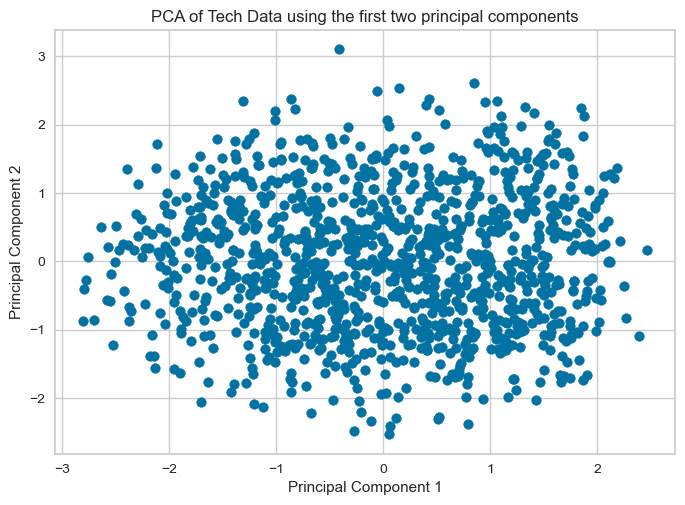

In [935]:
# Visualize the data in two dimensions using the first two principal components 

Y = PCA(n_components=2).fit_transform(data)
plt.scatter(Y[:, 0], Y[:, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Tech Data using the first two principal components')
plt.show()


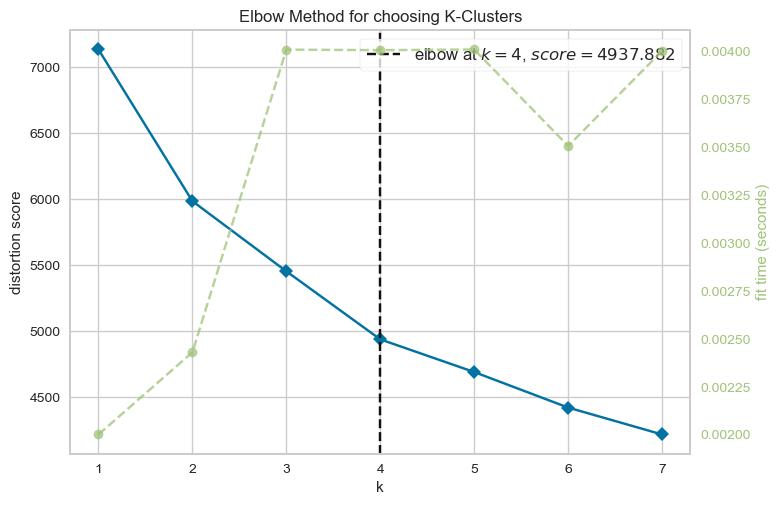

<Axes: title={'center': 'Elbow Method for choosing K-Clusters'}, xlabel='k', ylabel='distortion score'>

In [936]:
# In order to use K-Means clustering, first I want to use the elbow method to determine the optimal number of clusters

model = KMeans()
visualizer = KElbowVisualizer(model, k=(1, 8), timings=True)

# Fit the data to the visualizer
visualizer.fit(pca_data)
visualizer.title = 'Elbow Method for choosing K-Clusters'
visualizer.show()

In [937]:
# Fit KMeans Model using optimal number of clusters

kmeans = KMeans(n_clusters=3, random_state=0).fit(pca_data)

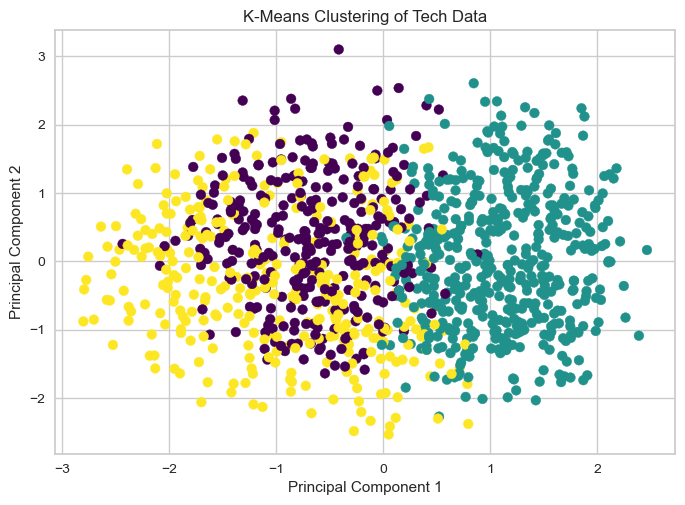

In [938]:
# Visualize the clusters in two dimensions

plt.scatter(Y[:, 0], Y[:, 1], c=kmeans.labels_, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-Means Clustering of Tech Data')

plt.show()

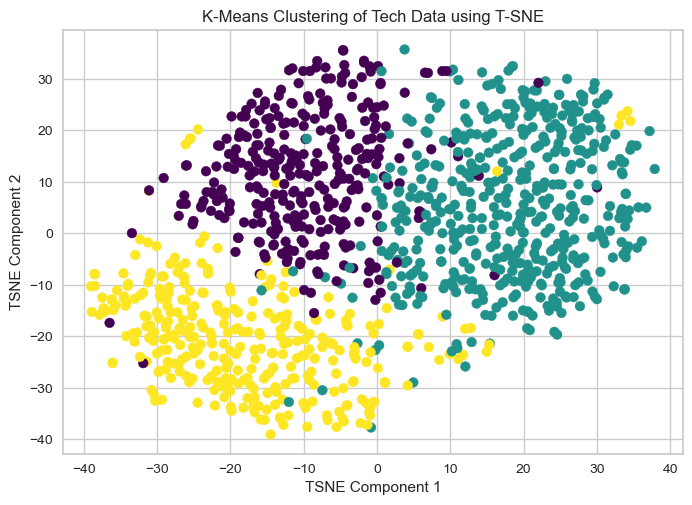

In [939]:
# Visualize the clusters using T-SNE

tsne = TSNE(n_components=2, random_state=0)
tsne_data = tsne.fit_transform(data)
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=kmeans.labels_, cmap='viridis')
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.title('K-Means Clustering of Tech Data using T-SNE')
plt.show()


In [940]:
# Inverse scale the data to get the original data

inverse_scale_data = scaler.inverse_transform(data)
data = pd.DataFrame(inverse_scale_data, columns=data.columns)

# Inverse transform data to back to original data frame format prior to OneHotEncoding, MultiLabelBinarizer, and OrdinalEncoder

# Inverse Transform One_Hot_Encoded Data
data = pd.concat([data.drop(columns=one_hot_data.columns), pd.DataFrame(encoder.inverse_transform(one_hot_data), columns=categorical_columns)], axis=1)

# Inverse Transform OrdinalEncoded Data
data = pd.concat([data.drop(columns=list(ordinal_features_categories.keys())), pd.DataFrame(ordinal_encoder.inverse_transform(ordinal_encoded), columns=list(ordinal_features_categories.keys()))], axis=1)

# Inverse transform MultiLabelBinarizer Rows and concatenate with original data set.

decoded_multi_data = one_hot_multiclass.inverse_transform(data[one_hot_multiclass.classes_].values)
data['work_position'] = ['|'.join(category) for category in decoded_multi_data]
data = data.drop(columns=one_hot_multiclass.classes_)

data.head()

,tech_company,mental_health_benefits,mental_health_coverage_awareness,mental_health_offical_communication,mental_health_resources,mental_health_anonymity,physical_same_mental,neg_consequences_open_mental_health,previous_employer,mental_health_career_impact,...,discussing_mental_health_with_employer,discussing_physical_health_with_employer,discussing_mental_health_with_coworker,discussing_mental_health_with_supervisor,physical_health_interview,mental_health_interview,current_employment_less_likely_to_reveal_mental_health_issue,past_history_mental_health,current_MH_disorder,work_position
0,Yes,Not eligible for coverage / N/A,Missing,No,No,I don't know,I don't know,No,Yes,Maybe,...,No,No,Maybe,Yes,Maybe,Maybe,Missing,Yes,No,Back-end Developer
1,Yes,No,Yes,Yes,Yes,Yes,Yes,No,Yes,"No, I don't think it would",...,No,No,Maybe,Yes,Maybe,No,Missing,Yes,Yes,Back-end Developer|Front-end Developer
2,Yes,No,Missing,No,No,I don't know,I don't know,No,Yes,Maybe,...,Maybe,No,Maybe,Maybe,Yes,Yes,Yes,Maybe,No,Back-end Developer
3,No,Yes,Yes,No,No,No,No,No,Yes,"Yes, I think it would",...,Yes,Maybe,Maybe,No,Maybe,No,Yes,Yes,Yes,Back-end Developer|Dev Evangelist/Advocate|Dev...
4,Yes,Yes,I am not sure,No,Yes,Yes,No,Yes,Yes,"Yes, I think it would",...,Yes,Yes,Maybe,Yes,Yes,Maybe,No,No,Yes,Back-end Developer|Designer|DevOps/SysAdmin|Fr...


In [941]:
# Add cluster labels to the data frame based on index

data['cluster'] = kmeans.labels_
data.head()


,tech_company,mental_health_benefits,mental_health_coverage_awareness,mental_health_offical_communication,mental_health_resources,mental_health_anonymity,physical_same_mental,neg_consequences_open_mental_health,previous_employer,mental_health_career_impact,...,discussing_physical_health_with_employer,discussing_mental_health_with_coworker,discussing_mental_health_with_supervisor,physical_health_interview,mental_health_interview,current_employment_less_likely_to_reveal_mental_health_issue,past_history_mental_health,current_MH_disorder,work_position,cluster
0,Yes,Not eligible for coverage / N/A,Missing,No,No,I don't know,I don't know,No,Yes,Maybe,...,No,Maybe,Yes,Maybe,Maybe,Missing,Yes,No,Back-end Developer,2
1,Yes,No,Yes,Yes,Yes,Yes,Yes,No,Yes,"No, I don't think it would",...,No,Maybe,Yes,Maybe,No,Missing,Yes,Yes,Back-end Developer|Front-end Developer,1
2,Yes,No,Missing,No,No,I don't know,I don't know,No,Yes,Maybe,...,No,Maybe,Maybe,Yes,Yes,Yes,Maybe,No,Back-end Developer,2
3,No,Yes,Yes,No,No,No,No,No,Yes,"Yes, I think it would",...,Maybe,Maybe,No,Maybe,No,Yes,Yes,Yes,Back-end Developer|Dev Evangelist/Advocate|Dev...,1
4,Yes,Yes,I am not sure,No,Yes,Yes,No,Yes,Yes,"Yes, I think it would",...,Yes,Maybe,Yes,Yes,Maybe,No,No,Yes,Back-end Developer|Designer|DevOps/SysAdmin|Fr...,2


In [942]:
# Calculate the overall Silhouette score

S= silhouette_score(pca_data, kmeans.labels_)
S


0.15385296195256637

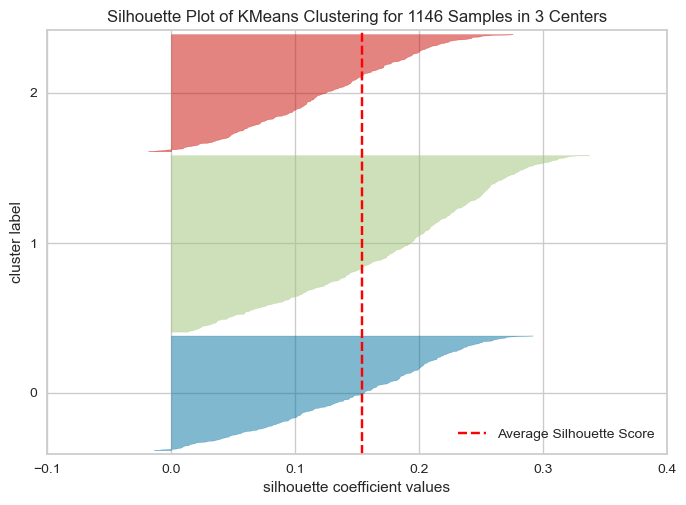

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 1146 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [943]:
# Generate, fit and show a Silhouette Visualizer

visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(pca_data)
visualizer.show()

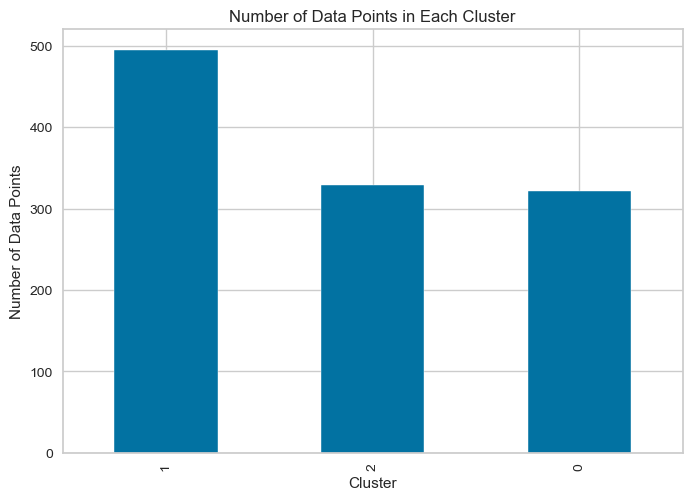

In [944]:
# Visualization of amount of data in each cluster 

data['cluster'].value_counts().plot(kind='bar')
plt.xlabel('Cluster')
plt.ylabel('Number of Data Points')
plt.title('Number of Data Points in Each Cluster')
plt.show()



In [945]:
# Visualization of Cluster Profiles using the top 15 features 

list_of_important_features = ["at_any_point_diagnosed_MH_disorder","treatment_MH_disorder", "past_history_mental_health", "interference_with_work_NOT_effective_treatment", "current_MH_disorder", "family_history_mental_health", "mental_health_benefits", "country_residence",  "country_work", "mental_health_coverage_awareness", "interference_with_work_with_effective_treatment", "previous_employer_mental_health_coverage_awareness", "previous_employer_mental_health_benefits", "gender", "current_employment_less_likely_to_reveal_mental_health_issue"]


In [946]:
# Use Grouped Box Plots to visualize data using Plotly. Using a separate Figure for each feature to describe the data in each cluster

for feature in list_of_important_features:
    fig = go.Figure()
    for cluster in data['cluster'].unique():
        fig.add_trace(go.Box(y=data[data['cluster'] == cluster][feature], name=f'Cluster {cluster}'))
    fig.update_layout(title=f'Box Plot of {feature} by Cluster')
    fig.show()



In [947]:
# Use Grouped Barcharts to visualize data using Plotly. Using a separate Figure for each feature to describe the data in each cluster

for feature in list_of_important_features:
    fig = go.Figure()
    for cluster in data['cluster'].unique():
        fig.add_trace(go.Histogram(x=data[data['cluster'] == cluster][feature], name=f'Cluster {cluster}', histnorm='percent'))
    fig.update_layout(title=f'Histogram of {feature} by Cluster')
    fig.show()